In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when create a version using "Save & Run All" 
# can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [1]:
!git clone https://github.com/marcusklasson/GroceryStoreDataset.git

fatal: destination path 'GroceryStoreDataset' already exists and is not an empty directory.


In [2]:
from pathlib import Path
from PIL import Image
from torch import Tensor
from torch.utils.data import Dataset
from typing import List, Tuple
import cv2
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
from torchvision import datasets, transforms
from torchvision.datasets import ImageFolder
import matplotlib.pyplot as plt
import itertools

In [3]:
class GroceryStoreDataset(Dataset):

    def __init__(self, split: str, transform=None) -> None:
        super().__init__()

        self.root = Path("GroceryStoreDataset/dataset")
        self.split = split
        self.paths, self.labels = self.read_file()

        self.transform = transform

    def __len__(self) -> int:
        return len(self.labels)

    def __getitem__(self, idx) -> Tuple[Tensor, int]:
        img = Image.open(self.root / self.paths[idx])
        label = self.labels[idx]

        if self.transform:
            img = self.transform(img)

        return img, label

    def read_file(self) -> Tuple[List[str], List[int]]:
        paths = []
        labels = []

        with open(self.root / f"{self.split}.txt") as f:
            for line in f:
                # path, fine-grained class, coarse-grained class
                path, _, label = line.replace("\n", "").split(", ")
                paths.append(path), labels.append(int(label))

        return paths, labels

    def get_num_classes(self) -> int:
        return max(self.labels) + 1

In [4]:
# Data preparation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

train_dataset = ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = ImageFolder(root=path2test, transform=data_transforms['test'])

train_loader = data.DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = data.DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = data.DataLoader(test_dataset, batch_size=32, shuffle=False)


In [7]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.7, 0.8]
learning_rates = [0.001]
optimizers = ['Adam']
#'SGD'
weight_decays = [0, 0.001]  # Will be set based on optimizer in the loop
momentums = [0.9, 0.99]  # Only for SGD
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

"""elif criterion_name == 'LabelSmoothingCrossEntropy':
        criterion = LabelSmoothingCrossEntropy()"""
"""elif optimizer_name == 'SGD':
        optimizer = optim.SGD(model.parameters(), lr=lr, momentum=momentum, weight_decay=weight_decay)"""

# Function to initialize model, criterion, and optimizer based on parameters
def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")


    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')


# Training function (simplified for the sake of example)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

    return model, train_loss, val_loss, train_acc, val_acc

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'SGD':
        for momentum in momentums:
            print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay=0, momentum={momentum}, criterion={criterion_name}')
            model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, 0, momentum, criterion_name)
            model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)
            # Save results for further analysis if needed
    elif optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, x, y, z, t = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)



Training with dropout_rate=0.7, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/25], Batch [0/83], Train Loss: 3.7259, Train Acc: 0.0312
Epoch [1/25], Batch [10/83], Train Loss: 1.8609, Train Acc: 0.3352
Epoch [1/25], Batch [20/83], Train Loss: 1.4826, Train Acc: 0.4435
Epoch [1/25], Batch [30/83], Train Loss: 1.3022, Train Acc: 0.4768
Epoch [1/25], Batch [40/83], Train Loss: 1.1957, Train Acc: 0.5030
Epoch [1/25], Batch [50/83], Train Loss: 1.1138, Train Acc: 0.5325
Epoch [1/25], Batch [60/83], Train Loss: 1.0586, Train Acc: 0.5487
Epoch [1/25], Batch [70/83], Train Loss: 1.0133, Train Acc: 0.5678
Epoch [1/25], Batch [80/83], Train Loss: 0.9751, Train Acc: 0.5826
Epoch [1/25] Train Loss: 0.9689, Train Acc: 0.5860, Val Loss: 1.0895, Val Acc: 0.5709
Epoch [2/25], Batch [0/83], Train Loss: 0.7761, Train Acc: 0.5938
Epoch [2/25], Batch [10/83], Train Loss: 0.7347, Train Acc: 0.6932
Epoch [2/25], Batch [20/83], Train Loss: 0.7046,

In [14]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/50], Batch [0/83], Train Loss: 3.7485, Train Acc: 0.0312
Epoch [1/50], Batch [10/83], Train Loss: 2.0787, Train Acc: 0.3011
Epoch [1/50], Batch [20/83], Train Loss: 1.6957, Train Acc: 0.3497
Epoch [1/50], Batch [30/83], Train Loss: 1.4755, Train Acc: 0.4093
Epoch [1/50], Batch [40/83], Train Loss: 1.3191, Train Acc: 0.4649
Epoch [1/50], Batch [50/83], Train Loss: 1.2231, Train Acc: 0.4939
Epoch [1/50], Batch [60/83], Train Loss: 1.1659, Train Acc: 0.5108
Epoch [1/50], Batch [70/83], Train Loss: 1.1131, Train Acc: 0.5335
Epoch [1/50], Batch [80/83], Train Loss: 1.0632, Train Acc: 0.5563
Epoch [1/50] Train Loss: 1.0618, Train Acc: 0.5572, Val Loss: 1.0042, Val Acc: 0.5777
Epoch [2/50], Batch [0/83], Train Loss: 0.9080, Train Acc: 0.6250
Epoch [2/50], Batch [10/83], Train Loss: 0.7402, Train Acc: 0.6818
Epoch [2/50], Batch [20/83], Train Loss: 0.7331,

In [9]:
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define the residual block
class ResidualBlock(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1):
        super(ResidualBlock, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1)
        self.bn1 = nn.BatchNorm2d(out_channels)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)
        self.skip_connection = nn.Sequential()

        # If the input and output dimensions do not match, use a convolutional layer to match them
        if stride != 1 or in_channels != out_channels:
            self.skip_connection = nn.Sequential(
                nn.Conv2d(in_channels, out_channels, kernel_size=1, stride=stride),
                nn.BatchNorm2d(out_channels)
            )

    def forward(self, x):
        identity = x
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)
        out = self.conv2(out)
        out = self.bn2(out)
        out += self.skip_connection(identity)
        out = self.relu(out)
        return out

# Define the CNN architecture with a residual block and configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.8):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(32, 64),
            nn.MaxPool2d(kernel_size=2, stride=2),
            ResidualBlock(64, 128),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

# Function to initialize model, criterion, and optimizer based on parameters
def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

# Training function (simplified for the sake of example)
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.001)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break

    return model, train_loss, val_loss, train_acc, val_acc

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'SGD':
        for momentum in momentums:
            print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay=0, momentum={momentum}, criterion={criterion_name}')
            model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, 0, momentum, criterion_name)
            model = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, patience=5)
            # Save results for further analysis if needed
    elif optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/25], Batch [0/83], Train Loss: 5.1491, Train Acc: 0.0000
Epoch [1/25], Batch [10/83], Train Loss: 17.4695, Train Acc: 0.4006
Epoch [1/25], Batch [20/83], Train Loss: 12.9282, Train Acc: 0.4792
Epoch [1/25], Batch [30/83], Train Loss: 9.9229, Train Acc: 0.5192
Epoch [1/25], Batch [40/83], Train Loss: 7.9891, Train Acc: 0.5465
Epoch [1/25], Batch [50/83], Train Loss: 6.6091, Train Acc: 0.5766
Epoch [1/25], Batch [60/83], Train Loss: 5.6675, Train Acc: 0.5886
Epoch [1/25], Batch [70/83], Train Loss: 4.9998, Train Acc: 0.5990
Epoch [1/25], Batch [80/83], Train Loss: 4.4750, Train Acc: 0.6115
Epoch [1/25] Train Loss: 4.4046, Train Acc: 0.6144, Val Loss: 0.8396, Val Acc: 0.6622
Epoch [2/25], Batch [0/83], Train Loss: 0.9367, Train Acc: 0.5312
Epoch [2/25], Batch [10/83], Train Loss: 0.7132, Train Acc: 0.6960
Epoch [2/25], Batch [20/83], Train Loss: 0.691

In [8]:
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/50], Batch [0/165], Train Loss: 3.7359, Train Acc: 0.0625
Epoch [1/50], Batch [10/165], Train Loss: 2.1355, Train Acc: 0.3523
Epoch [1/50], Batch [20/165], Train Loss: 1.7686, Train Acc: 0.3631
Epoch [1/50], Batch [30/165], Train Loss: 1.5761, Train Acc: 0.3931
Epoch [1/50], Batch [40/165], Train Loss: 1.4128, Train Acc: 0.4345
Epoch [1/50], Batch [50/165], Train Loss: 1.2860, Train Acc: 0.4767
Epoch [1/50], Batch [60/165], Train Loss: 1.2280, Train Acc: 0.4949
Epoch [1/50], Batch [70/165], Train Loss: 1.1628, Train Acc: 0.5167
Epoch [1/50], Batch [80/165], Train Loss: 1.1345, Train Acc: 0.5285
Epoch [1/50], Batch [90/165], Train Loss: 1.1073, Train Acc: 0.5378
Epoch [1/50], Batch [100/165], Train Loss: 1.0782, Train Acc: 0.5526
Epoch [1/50], Batch [110/165], Train Loss: 1.0411, Train Acc: 0.5659
Epoch [1/50], Batch [120/165], Train Loss: 1.0150, T

In [16]:
evaluate_model(model, val_loader)


Test Accuracy: 0.7534


In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=50, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Using device: cuda
Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/50], Batch [0/165], Train Loss: 3.7806, Train Acc: 0.0000
Epoch [1/50], Batch [10/165], Train Loss: 2.1214, Train Acc: 0.2898
Epoch [1/50], Batch [20/165], Train Loss: 1.7181, Train Acc: 0.3542
Epoch [1/50], Batch [30/165], Train Loss: 1.5641, Train Acc: 0.3468
Epoch [1/50], Batch [40/165], Train Loss: 1.4619, Train Acc: 0.3659
Epoch [1/50], Batch [50/165], Train Loss: 1.3867, Train Acc: 0.3946
Epoch [1/50], Batch [60/165], Train Loss: 1.3189, Train Acc: 0.4201
Epoch [1/50], Batch [70/165], Train Loss: 1.2567, Train Acc: 0.4463
Epoch [1/50], Batch [80/165], Train Loss: 1.2180, Train Acc: 0.4645
Epoch [1/50], Batch [90/165], Train Loss: 1.1852, Train Acc: 0.4746
Epoch [1/50], Batch [100/165], Train Loss: 1.1550, Train Acc: 0.4901
Epoch [1/50], Batch [110/165], Train Loss: 1.1278, Train Acc: 0.5017
Epoch [1/50], Batch [120/165], Tr

In [2]:
evaluate_model(model, val_loader)


Test Accuracy: 0.7297


In [5]:
#new_job_new_code_here_we_go_again_ah_shit

In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

from collections import defaultdict

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    misclassifications = defaultdict(list)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect misclassified examples
            for label, prediction in zip(labels, predicted):
                if label != prediction:
                    misclassifications[label.item()].append(prediction.item())

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

    # Print misclassification details
    for label, predictions in misclassifications.items():
        print(f'{len(predictions)} data from class number {label} wrongly labeled as {predictions}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Using device: cuda
Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/20], Batch [0/165], Train Loss: 3.7882, Train Acc: 0.0000
Epoch [1/20], Batch [10/165], Train Loss: 2.0334, Train Acc: 0.3920
Epoch [1/20], Batch [20/165], Train Loss: 1.7185, Train Acc: 0.4077
Epoch [1/20], Batch [30/165], Train Loss: 1.5861, Train Acc: 0.4113
Epoch [1/20], Batch [40/165], Train Loss: 1.4610, Train Acc: 0.4314
Epoch [1/20], Batch [50/165], Train Loss: 1.3867, Train Acc: 0.4571
Epoch [1/20], Batch [60/165], Train Loss: 1.3144, Train Acc: 0.4816
Epoch [1/20], Batch [70/165], Train Loss: 1.2652, Train Acc: 0.4965
Epoch [1/20], Batch [80/165], Train Loss: 1.2057, Train Acc: 0.5139
Epoch [1/20], Batch [90/165], Train Loss: 1.1855, Train Acc: 0.5185
Epoch [1/20], Batch [100/165], Train Loss: 1.1607, Train Acc: 0.5260
Epoch [1/20], Batch [110/165], Train Loss: 1.1290, Train Acc: 0.5377
Epoch [1/20], Batch [120/165], Tr

In [15]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

def loader_init():
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)
    val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)
    return train_loader, val_loader, test_loader
    
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4, persistent_workers=True)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4, persistent_workers=True)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True

    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class SimpleCNN(nn.Module):
    def __init__(self, conv_layers='light', fc_layers='heavy', num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        
        if conv_layers == 'light':
            self.features = nn.Sequential(
                nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )
        elif conv_layers == 'heavy':
            self.features = nn.Sequential(
                nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2),
                nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
                nn.ReLU(inplace=True),
                nn.MaxPool2d(kernel_size=2, stride=2)
            )

        self.pool = nn.AdaptiveAvgPool2d((7, 7))

        if fc_layers == 'light':
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout_rate),
                nn.Linear(512 * 7 * 7 if conv_layers == 'heavy' else 128 * 7 * 7, 64),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_rate),
                nn.Linear(64, num_classes)
            )
        elif fc_layers == 'heavy':
            self.classifier = nn.Sequential(
                nn.Dropout(p=dropout_rate),
                nn.Linear(512 * 7 * 7 if conv_layers == 'heavy' else 128 * 7 * 7, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(p=dropout_rate),
                nn.Linear(512, num_classes)
            )

    def forward(self, x):
        x = self.features(x)
        x = self.pool(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

networks = {
    '1': SimpleCNN(conv_layers='light', fc_layers='heavy', num_classes=43, dropout_rate=0.5),
    '2': SimpleCNN(conv_layers='heavy', fc_layers='light', num_classes=43, dropout_rate=0.5),
    '3': SimpleCNN(conv_layers='light', fc_layers='light', num_classes=43, dropout_rate=0.5),
    '4': SimpleCNN(conv_layers='heavy', fc_layers='heavy', num_classes=43, dropout_rate=0.5)
}

def initialize_model(network, dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = networks[network].to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

from collections import defaultdict

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    misclassifications = defaultdict(list)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            for label, prediction in zip(labels, predicted):
                if label != prediction:
                    misclassifications[label.item()].append(prediction.item())

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

    for label, predictions in misclassifications.items():
        print(f'{len(predictions)} data from class number {label} wrongly labeled as {predictions}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''
nw_name = {
    '1': 'light_heavy',
    '2': 'heavy_light',
    '3': 'light_light',
    '4': 'heavy_heavy'
}

nw_list = ['2', '3', '4']
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    for nw in nw_list:
        print("network arch is: {}".format(nw_name[nw]))
        if optimizer_name == 'Adam':
            weight_decay = 0.0001
            print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
            model, criterion, optimizer = initialize_model(nw, dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
            try:
                model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=20, patience=10)
            finally:
                del train_loader, val_loader, test_loader
                torch.cuda.empty_cache()
                train_loader, val_loader, test_loader = loader_init()
            evaluate_model(model, test_loader)


Using device: cuda
network arch is: heavy_light
Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/20], Batch [0/165], Train Loss: 3.7048, Train Acc: 0.0000
Epoch [1/20], Batch [10/165], Train Loss: 2.5103, Train Acc: 0.2784
Epoch [1/20], Batch [20/165], Train Loss: 2.1712, Train Acc: 0.3542
Epoch [1/20], Batch [30/165], Train Loss: 1.9667, Train Acc: 0.3891
Epoch [1/20], Batch [40/165], Train Loss: 1.8321, Train Acc: 0.3933
Epoch [1/20], Batch [50/165], Train Loss: 1.7955, Train Acc: 0.3762
Epoch [1/20], Batch [60/165], Train Loss: 1.7224, Train Acc: 0.3842
Epoch [1/20], Batch [70/165], Train Loss: 1.6792, Train Acc: 0.3812
Epoch [1/20], Batch [80/165], Train Loss: 1.6487, Train Acc: 0.3781
Epoch [1/20], Batch [90/165], Train Loss: 1.6209, Train Acc: 0.3743
Epoch [1/20], Batch [100/165], Train Loss: 1.5880, Train Acc: 0.3787
Epoch [1/20], Batch [110/165], Train Loss: 1.5602, Train Acc: 0.3823
Epoc

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.model = None
    
    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.model = model
        elif val_loss < self.best_loss - self.min_delta:
            self.best_loss = val_loss
            self.counter = 0
            self.model = model
        else:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
    def getmodel(self):
        return self.model
                
import itertools
import torch
import torch.nn as nn
import torch.optim as optim

# Define values
dropout_rates = [0.8]
learning_rates = [0.001]
optimizers = ['Adam']
weight_decays = [0, 0.001]
momentums = [0.9, 0.99]
criteria = ['CrossEntropyLoss']

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Define the CNN architecture with configurable dropout
class SimpleCNN(nn.Module):
    def __init__(self, num_classes=43, dropout_rate=0.5):
        super(SimpleCNN, self).__init__()
        self.features = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.classifier = nn.Sequential(
            nn.Dropout(p=dropout_rate),
            nn.Linear(128 * 28 * 28, 512),
            nn.ReLU(inplace=True),
            nn.Dropout(p=dropout_rate),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)
        x = self.classifier(x)
        return x

def initialize_model(dropout_rate, lr, optimizer_name, weight_decay, momentum, criterion_name):
    model = SimpleCNN(num_classes=43, dropout_rate=dropout_rate).to(device)

    if criterion_name == 'CrossEntropyLoss':
        criterion = nn.CrossEntropyLoss()
    else:
        raise ValueError("Unsupported criterion")

    if optimizer_name == 'Adam':
        optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    else:
        raise ValueError("Unsupported optimizer")

    return model, criterion, optimizer

from collections import defaultdict

def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0
    misclassifications = defaultdict(list)

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Collect misclassified examples
            for label, prediction in zip(labels, predicted):
                if label != prediction:
                    misclassifications[label.item()].append(prediction.item())

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

    # Print misclassification details
    for label, predictions in misclassifications.items():
        print(f'{len(predictions)} data from class number {label} wrongly labeled as {predictions}')

def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=15, patience=5):
    train_loss = []
    val_loss = []
    train_acc = []
    val_acc = []

    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Train Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Train Acc: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_loss.append(epoch_loss)
        train_acc.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_loss.append(val_epoch_loss)
        val_acc.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

    return model, train_loss, val_loss, train_acc, val_acc

model = ''

# Experiment with different hyperparameters
for dropout_rate, lr, optimizer_name, criterion_name in itertools.product(dropout_rates, learning_rates, optimizers, criteria):
    if optimizer_name == 'Adam':
        weight_decay = 0.0001
        print(f'Training with dropout_rate={dropout_rate}, lr={lr}, optimizer={optimizer_name}, weight_decay={weight_decay}, momentum=not applicable, criterion={criterion_name}')
        model, criterion, optimizer = initialize_model(dropout_rate, lr, optimizer_name, weight_decay, None, criterion_name)
        model, train_loss, val_loss, train_acc, val_acc = train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=1, patience=10)
        # Save results for further analysis if needed
        evaluate_model(model, test_loader)


Using device: cuda
Training with dropout_rate=0.8, lr=0.001, optimizer=Adam, weight_decay=0.0001, momentum=not applicable, criterion=CrossEntropyLoss
Epoch [1/1], Batch [0/165], Train Loss: 3.7534, Train Acc: 0.0000
Epoch [1/1], Batch [10/165], Train Loss: 2.0825, Train Acc: 0.3239
Epoch [1/1], Batch [20/165], Train Loss: 1.7393, Train Acc: 0.3571
Epoch [1/1], Batch [30/165], Train Loss: 1.6024, Train Acc: 0.3669
Epoch [1/1], Batch [40/165], Train Loss: 1.4972, Train Acc: 0.3689
Epoch [1/1], Batch [50/165], Train Loss: 1.4030, Train Acc: 0.3909
Epoch [1/1], Batch [60/165], Train Loss: 1.3499, Train Acc: 0.4232
Epoch [1/1], Batch [70/165], Train Loss: 1.2987, Train Acc: 0.4428
Epoch [1/1], Batch [80/165], Train Loss: 1.2462, Train Acc: 0.4591
Epoch [1/1], Batch [90/165], Train Loss: 1.1996, Train Acc: 0.4753
Epoch [1/1], Batch [100/165], Train Loss: 1.1673, Train Acc: 0.4926
Epoch [1/1], Batch [110/165], Train Loss: 1.1352, Train Acc: 0.5045
Epoch [1/1], Batch [120/165], Train Loss: 1.1

Counter({0: 1142, 1: 864, 2: 634})


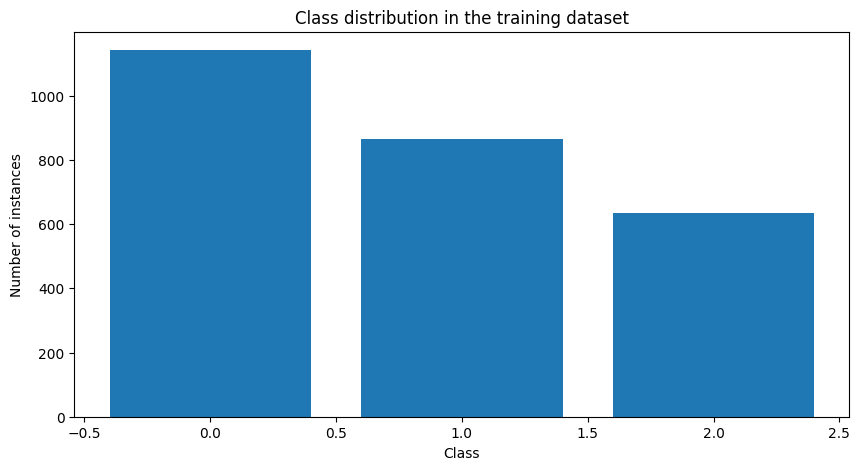

In [7]:
from collections import Counter
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

def get_class_distribution(dataset):
    labels = dataset.targets
    class_count = Counter(labels)
    return class_count

def plot_class_distribution(class_count):
    classes = list(class_count.keys())
    counts = list(class_count.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts)
    plt.xlabel('Class')
    plt.ylabel('Number of instances')
    plt.title('Class distribution in the training dataset')
    plt.show()

# Get and plot class distribution
class_count = get_class_distribution(train_dataset)
print(class_count)
plot_class_distribution(class_count)

Class count: Counter({12: 70, 8: 57, 1: 46, 9: 45, 30: 43, 11: 42, 14: 41, 39: 39, 7: 37, 15: 36, 0: 34, 2: 32, 5: 31, 32: 30, 17: 28, 36: 28, 13: 26, 18: 26, 31: 25, 40: 23, 6: 22, 33: 22, 4: 21, 35: 19, 37: 19, 28: 18, 29: 16})


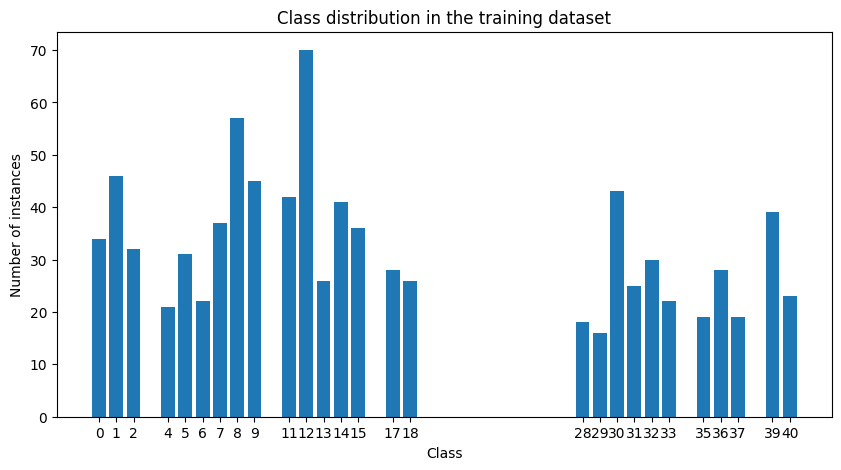

Class to index mapping: {'Red-Grapefruit': 0, 'Kiwi': 1, 'Mango': 2, 'Melon': 3, 'Papaya': 4, 'Lime': 5, 'Plum': 6, 'Peach': 7, 'Orange': 8, 'Banana': 9, 'Apple': 10, 'Lemon': 11, 'Satsumas': 12, 'Pomegranate': 13, 'Avocado': 14, 'Nectarine': 15, 'Pear': 16, 'Passion-Fruit': 17, 'Pineapple': 18, 'Milk': 19, 'Oat-Milk': 20, 'Soyghurt': 21, 'Sour-Cream': 22, 'Juice': 23, 'Soy-Milk': 24, 'Sour-Milk': 25, 'Oatghurt': 26, 'Yoghurt': 27, 'Red-Beet': 28, 'Asparagus': 29, 'Carrots': 30, 'Garlic': 31, 'Zucchini': 32, 'Aubergine': 33, 'Pepper': 34, 'Ginger': 35, 'Cucumber': 36, 'Cabbage': 37, 'Onion': 38, 'Brown-Cap-Mushroom': 39, 'Leek': 40, 'Potato': 41, 'Tomato': 42}
Index to class mapping: {0: 'Red-Grapefruit', 1: 'Kiwi', 2: 'Mango', 3: 'Melon', 4: 'Papaya', 5: 'Lime', 6: 'Plum', 7: 'Peach', 8: 'Orange', 9: 'Banana', 10: 'Apple', 11: 'Lemon', 12: 'Satsumas', 13: 'Pomegranate', 14: 'Avocado', 15: 'Nectarine', 16: 'Pear', 17: 'Passion-Fruit', 18: 'Pineapple', 19: 'Milk', 20: 'Oat-Milk', 21: 'S

In [11]:
import os
from torchvision import transforms
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import matplotlib.pyplot as plt
from collections import Counter

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        self.class_to_idx = {}
        self.idx_to_class = {}
        
        current_label = 0

        # Traverse the root directory to get image paths and labels
        for parent_dir in os.listdir(root_dir):
            parent_path = os.path.join(root_dir, parent_dir)
            if os.path.isdir(parent_path):
                for label_dir in os.listdir(parent_path):
                    label_path = os.path.join(parent_path, label_dir)
                    if os.path.isdir(label_path):
                        if label_dir not in self.class_to_idx:
                            self.class_to_idx[label_dir] = current_label
                            self.idx_to_class[current_label] = label_dir
                            current_label += 1
                        label_idx = self.class_to_idx[label_dir]
                        for img_name in os.listdir(label_path):
                            if img_name.endswith(('jpg', 'jpeg', 'png')):
                                img_path = os.path.join(label_path, img_name)
                                self.samples.append((img_path, label_idx))
                                # Debugging print statement
                                print(f"Loaded {img_name} from {label_path} as class {label_dir} with index {label_idx}")

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
    'test': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Load the datasets
train_dataset = CustomImageDataset(root_dir=path2train, transform=data_transforms['train'])
val_dataset = CustomImageDataset(root_dir=path2val, transform=data_transforms['val'])
test_dataset = CustomImageDataset(root_dir=path2test, transform=data_transforms['test'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

def get_class_distribution(dataset):
    labels = [label for _, label in dataset.samples]
    class_count = Counter(labels)
    return class_count

def plot_class_distribution(class_count):
    classes = list(class_count.keys())
    counts = list(class_count.values())
    plt.figure(figsize=(10, 5))
    plt.bar(classes, counts, tick_label=classes)
    plt.xlabel('Class')
    plt.ylabel('Number of instances')
    plt.title('Class distribution in the training dataset')
    plt.show()

# Get and plot class distribution
class_count = get_class_distribution(train_dataset)
print("Class count:", class_count)
plot_class_distribution(class_count)

# Verify the class-to-index mapping
print("Class to index mapping:", train_dataset.class_to_idx)
print("Index to class mapping:", train_dataset.idx_to_class)


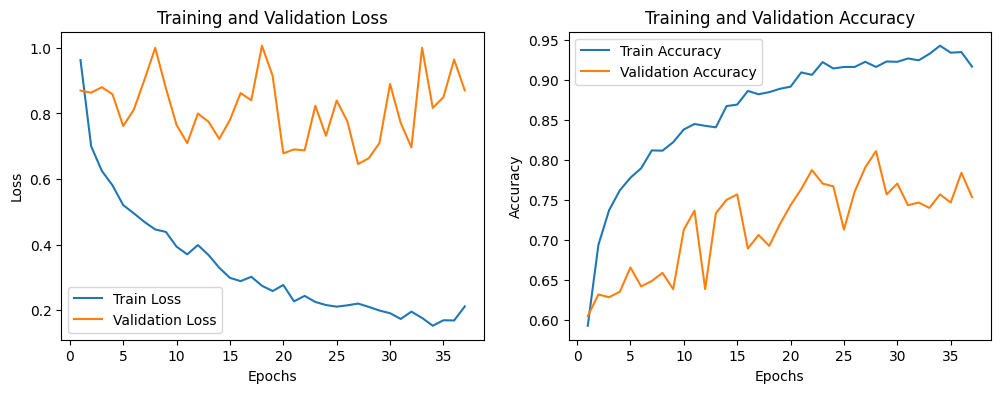

In [19]:
import matplotlib.pyplot as plt

# Assume train_loss, val_loss, train_acc, val_acc are lists that contain the loss and accuracy values for each epoch
# For this example, let's assume they were returned by train_model function

# Plot training results
epochs = range(1, len(train_loss) + 1)

plt.figure(figsize=(12, 4))

# Plot training and validation loss
plt.subplot(1, 2, 1)
plt.plot(epochs, train_loss, label='Train Loss')
plt.plot(epochs, val_loss, label='Validation Loss')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')

# Plot training and validation accuracy
plt.subplot(1, 2, 2)
plt.plot(epochs, train_acc, label='Train Accuracy')
plt.plot(epochs, val_acc, label='Validation Accuracy')
plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy')

plt.show()


In [7]:
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 43)  # Adjust the final layer to the number of classes
resnet18 = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Print training status every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Accuracy: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        # Early stopping: save the model if validation loss decreases
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model

# Train the model
resnet18 = train_model(resnet18, criterion, optimizer, train_loader, val_loader, num_epochs=25)

# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(resnet18, test_loader)


Using device: cuda


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 171MB/s]


Epoch [1/25], Batch [0/165], Loss: 3.9204, Accuracy: 0.0000
Epoch [1/25], Batch [10/165], Loss: 1.0244, Accuracy: 0.7500
Epoch [1/25], Batch [20/165], Loss: 0.8183, Accuracy: 0.7679
Epoch [1/25], Batch [30/165], Loss: 0.7068, Accuracy: 0.7823
Epoch [1/25], Batch [40/165], Loss: 0.6754, Accuracy: 0.7759
Epoch [1/25], Batch [50/165], Loss: 0.6647, Accuracy: 0.7721
Epoch [1/25], Batch [60/165], Loss: 0.6259, Accuracy: 0.7787
Epoch [1/25], Batch [70/165], Loss: 0.5889, Accuracy: 0.7826
Epoch [1/25], Batch [80/165], Loss: 0.5657, Accuracy: 0.7863
Epoch [1/25], Batch [90/165], Loss: 0.5410, Accuracy: 0.7940
Epoch [1/25], Batch [100/165], Loss: 0.5320, Accuracy: 0.7970
Epoch [1/25], Batch [110/165], Loss: 0.5238, Accuracy: 0.7956
Epoch [1/25], Batch [120/165], Loss: 0.5128, Accuracy: 0.8006
Epoch [1/25], Batch [130/165], Loss: 0.5016, Accuracy: 0.8044
Epoch [1/25], Batch [140/165], Loss: 0.4890, Accuracy: 0.8103
Epoch [1/25], Batch [150/165], Loss: 0.4813, Accuracy: 0.8158
Epoch [1/25], Batch

In [3]:
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 43)  # Adjust the final layer to the number of classes
resnet18 = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)

# Training function
def train_model(model, criterion, optimizer, train_loader, val_loader, num_epochs=25):
    best_val_loss = float('inf')
    best_model_wts = model.state_dict()

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)  # Move data to device

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

            # Print training status every 10 batches
            if batch_idx % 10 == 0:
                print(f'Epoch [{epoch+1}/{num_epochs}], Batch [{batch_idx}/{len(train_loader)}], '
                      f'Loss: {running_loss/((batch_idx+1)*train_loader.batch_size):.4f}, '
                      f'Accuracy: {correct/total:.4f}')

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)  # Move data to device
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        # Early stopping: save the model if validation loss decreases
        if val_epoch_loss < best_val_loss:
            best_val_loss = val_epoch_loss
            best_model_wts = model.state_dict()

    # Load best model weights
    model.load_state_dict(best_model_wts)
    return model


Using device: cuda


Using device: cuda
Epoch [1/25] Train Loss: 0.5670, Train Acc: 0.7780, Val Loss: 1.0291, Val Acc: 0.6486
Epoch [2/25] Train Loss: 0.3689, Train Acc: 0.8455, Val Loss: 0.6478, Val Acc: 0.7939
Epoch [3/25] Train Loss: 0.2907, Train Acc: 0.8841, Val Loss: 0.4299, Val Acc: 0.8243
Epoch [4/25] Train Loss: 0.2620, Train Acc: 0.8947, Val Loss: 0.4386, Val Acc: 0.8007
Epoch [5/25] Train Loss: 0.2106, Train Acc: 0.9110, Val Loss: 0.2561, Val Acc: 0.8851
Epoch [6/25] Train Loss: 0.2068, Train Acc: 0.9170, Val Loss: 0.3488, Val Acc: 0.8277
Epoch [7/25] Train Loss: 0.2111, Train Acc: 0.9299, Val Loss: 0.5256, Val Acc: 0.8547
Epoch [8/25] Train Loss: 0.1418, Train Acc: 0.9485, Val Loss: 0.1651, Val Acc: 0.9291
Epoch [9/25] Train Loss: 0.0860, Train Acc: 0.9670, Val Loss: 0.1410, Val Acc: 0.9527
Epoch [10/25] Train Loss: 0.0763, Train Acc: 0.9746, Val Loss: 0.1650, Val Acc: 0.9459
Epoch [11/25] Train Loss: 0.0585, Train Acc: 0.9792, Val Loss: 0.1562, Val Acc: 0.9459
Epoch [12/25] Train Loss: 0.0766,

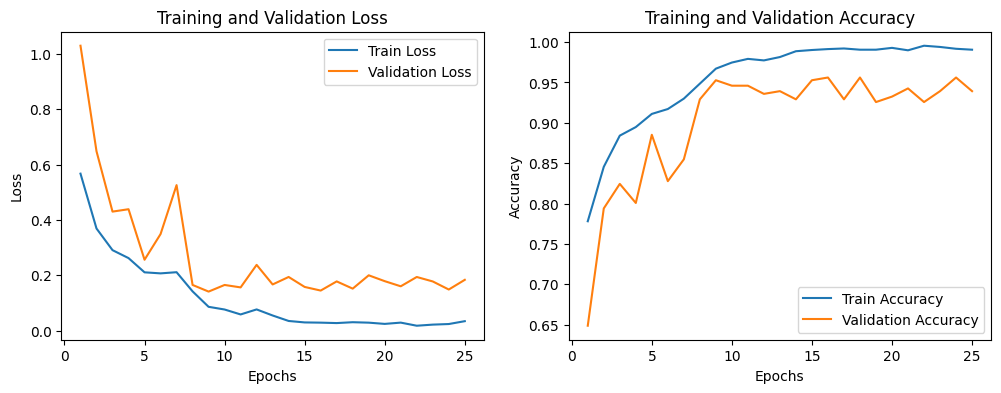

Test Accuracy: 0.9497


In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 43)  # Adjust the final layer to the number of classes
resnet18 = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25):
    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
resnet18, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    resnet18, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25
)

# Plot training results
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(resnet18, test_loader)


Using device: cuda
Epoch [1/25] Train Loss: 0.5804, Train Acc: 0.7610, Val Loss: 0.3668, Val Acc: 0.8649
Epoch [2/25] Train Loss: 0.3847, Train Acc: 0.8447, Val Loss: 0.5789, Val Acc: 0.7804
Epoch [3/25] Train Loss: 0.3020, Train Acc: 0.8792, Val Loss: 0.3947, Val Acc: 0.8108
Epoch [4/25] Train Loss: 0.2909, Train Acc: 0.8754, Val Loss: 0.5950, Val Acc: 0.7568
Epoch [5/25] Train Loss: 0.2354, Train Acc: 0.9102, Val Loss: 0.4669, Val Acc: 0.7635
Epoch [6/25] Train Loss: 0.2045, Train Acc: 0.9216, Val Loss: 0.4671, Val Acc: 0.8750
Epoch [7/25] Train Loss: 0.1827, Train Acc: 0.9303, Val Loss: 0.1464, Val Acc: 0.9358
Epoch [8/25] Train Loss: 0.0884, Train Acc: 0.9701, Val Loss: 0.1070, Val Acc: 0.9561
Epoch [9/25] Train Loss: 0.0760, Train Acc: 0.9720, Val Loss: 0.1303, Val Acc: 0.9595
Epoch [10/25] Train Loss: 0.0683, Train Acc: 0.9754, Val Loss: 0.1280, Val Acc: 0.9493
Epoch [11/25] Train Loss: 0.0469, Train Acc: 0.9837, Val Loss: 0.1092, Val Acc: 0.9662
Epoch [12/25] Train Loss: 0.0467,

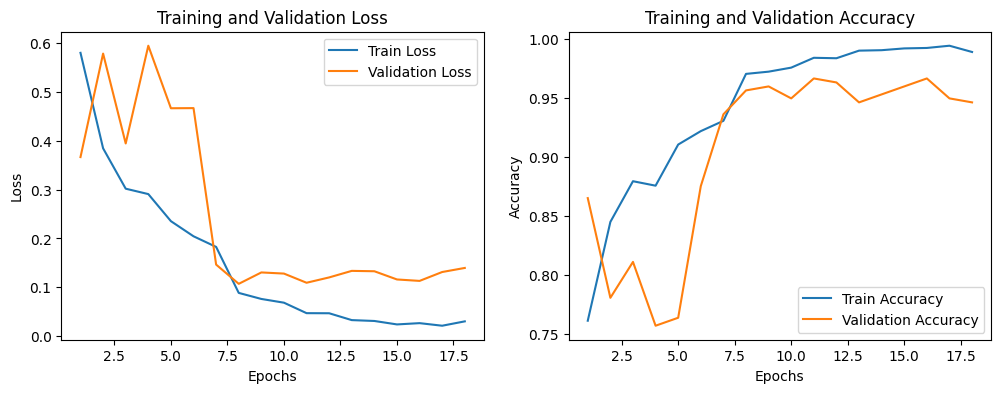

Test Accuracy: 0.9513


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Load the pretrained ResNet-18 model
resnet18 = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
num_ftrs = resnet18.fc.in_features
resnet18.fc = nn.Linear(num_ftrs, 43)  # Adjust the final layer to the number of classes
resnet18 = resnet18.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(resnet18.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Training function with early stopping
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=5):
    best_val_acc = 0.0
    best_model_wts = model.state_dict()
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model = early_stopping.getmodel()
            break

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# Train the model
resnet18, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
    resnet18, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=10
)

# Plot training results
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

# Evaluate the model on test data
def evaluate_model(model, test_loader):
    model.eval()
    correct = 0
    total = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

    acc = correct / total
    print(f'Test Accuracy: {acc:.4f}')

evaluate_model(resnet18, test_loader)


Using device: cuda
Training with step_size=5 and gamma=0.1
Epoch [1/25] Train Loss: 0.5752, Train Acc: 0.7686, Val Loss: 0.4719, Val Acc: 0.7703
Epoch [2/25] Train Loss: 0.3634, Train Acc: 0.8527, Val Loss: 0.6862, Val Acc: 0.7838
Epoch [3/25] Train Loss: 0.3107, Train Acc: 0.8758, Val Loss: 0.2753, Val Acc: 0.8649
Epoch [4/25] Train Loss: 0.2474, Train Acc: 0.8943, Val Loss: 0.3263, Val Acc: 0.9020
Epoch [5/25] Train Loss: 0.2643, Train Acc: 0.9004, Val Loss: 0.2376, Val Acc: 0.9020
Epoch [6/25] Train Loss: 0.1401, Train Acc: 0.9481, Val Loss: 0.1734, Val Acc: 0.9459
Epoch [7/25] Train Loss: 0.1106, Train Acc: 0.9595, Val Loss: 0.1887, Val Acc: 0.9392
Epoch [8/25] Train Loss: 0.0830, Train Acc: 0.9689, Val Loss: 0.1636, Val Acc: 0.9561
Epoch [9/25] Train Loss: 0.0985, Train Acc: 0.9670, Val Loss: 0.1720, Val Acc: 0.9561
Epoch [10/25] Train Loss: 0.0818, Train Acc: 0.9693, Val Loss: 0.1438, Val Acc: 0.9527
Epoch [11/25] Train Loss: 0.0655, Train Acc: 0.9765, Val Loss: 0.1400, Val Acc: 

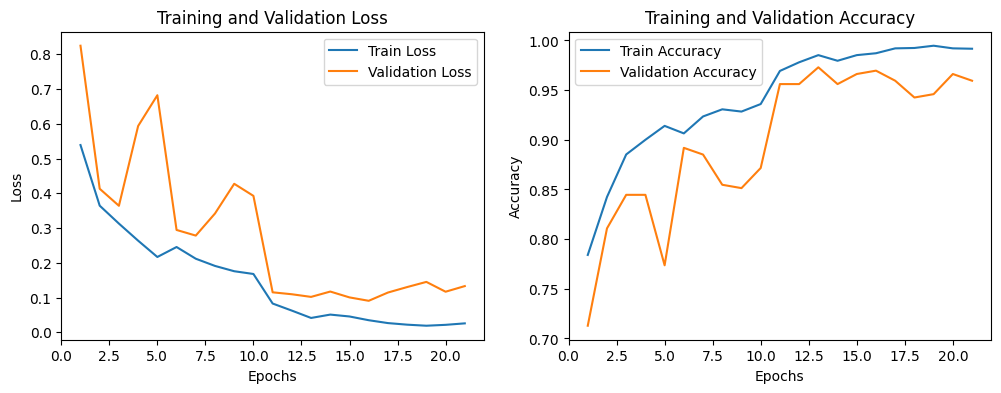

Epoch [1/25] Train Loss: 0.6030, Train Acc: 0.7462, Val Loss: 0.8927, Val Acc: 0.5811
Epoch [2/25] Train Loss: 0.4151, Train Acc: 0.8432, Val Loss: 0.6314, Val Acc: 0.7568
Epoch [3/25] Train Loss: 0.3151, Train Acc: 0.8746, Val Loss: 0.8124, Val Acc: 0.7128
Epoch [4/25] Train Loss: 0.3100, Train Acc: 0.8735, Val Loss: 0.4397, Val Acc: 0.8514
Epoch [5/25] Train Loss: 0.2126, Train Acc: 0.9064, Val Loss: 0.4173, Val Acc: 0.8615
Epoch [6/25] Train Loss: 0.2267, Train Acc: 0.9098, Val Loss: 0.5560, Val Acc: 0.7770
Epoch [7/25] Train Loss: 0.2313, Train Acc: 0.9087, Val Loss: 0.5538, Val Acc: 0.8041
Epoch [8/25] Train Loss: 0.2030, Train Acc: 0.9242, Val Loss: 0.2439, Val Acc: 0.8851
Epoch [9/25] Train Loss: 0.1642, Train Acc: 0.9417, Val Loss: 0.2578, Val Acc: 0.8885
Epoch [10/25] Train Loss: 0.2128, Train Acc: 0.9254, Val Loss: 0.2928, Val Acc: 0.8986
Epoch [11/25] Train Loss: 0.0954, Train Acc: 0.9629, Val Loss: 0.1619, Val Acc: 0.9527
Epoch [12/25] Train Loss: 0.0650, Train Acc: 0.9750,

In [10]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

# Paths to dataset
path2train = "/kaggle/working/GroceryStoreDataset/dataset/train"
path2val = "/kaggle/working/GroceryStoreDataset/dataset/val"
path2test = "/kaggle/working/GroceryStoreDataset/dataset/test"

# Check if GPU is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f'Using device: {device}')

# Data transformations
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomHorizontalFlip(),
        transforms.RandomRotation(10),
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2),
        transforms.ToTensor(),
    ]),
    'val': transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ]),
}

# Load the datasets
train_dataset = datasets.ImageFolder(root=path2train, transform=data_transforms['train'])
val_dataset = datasets.ImageFolder(root=path2val, transform=data_transforms['val'])
test_dataset = datasets.ImageFolder(root=path2test, transform=data_transforms['val'])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=4)

# Define the model
def create_model():
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_ftrs = model.fc.in_features
    model.fc = nn.Linear(num_ftrs, 43)  # Adjust the final layer to the number of classes
    return model.to(device)

# Define loss function
criterion = nn.CrossEntropyLoss()

# Early stopping class
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.best_loss = None
        self.early_stop = False
        self.best_model_wts = None

    def __call__(self, val_loss, model):
        if self.best_loss is None:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
        elif val_loss > self.best_loss - self.min_delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_loss = val_loss
            self.best_model_wts = model.state_dict()
            self.counter = 0

    def get_best_model_wts(self):
        return self.best_model_wts

# Training function
def train_model(model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=5):
    best_val_acc = 0.0
    train_losses, val_losses = [], []
    train_accuracies, val_accuracies = [], []
    early_stopping = EarlyStopping(patience=patience, min_delta=0.01)

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        correct = 0
        total = 0

        for batch_idx, (inputs, labels) in enumerate(train_loader):
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            _, predicted = outputs.max(1)
            total += labels.size(0)
            correct += predicted.eq(labels).sum().item()

        epoch_loss = running_loss / len(train_loader.dataset)
        epoch_acc = correct / total
        train_losses.append(epoch_loss)
        train_accuracies.append(epoch_acc)

        model.eval()
        val_running_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_running_loss += loss.item() * inputs.size(0)
                _, predicted = outputs.max(1)
                val_total += labels.size(0)
                val_correct += predicted.eq(labels).sum().item()

        val_epoch_loss = val_running_loss / len(val_loader.dataset)
        val_epoch_acc = val_correct / val_total
        val_losses.append(val_epoch_loss)
        val_accuracies.append(val_epoch_acc)

        print(f'Epoch [{epoch+1}/{num_epochs}] Train Loss: {epoch_loss:.4f}, Train Acc: {epoch_acc:.4f}, '
              f'Val Loss: {val_epoch_loss:.4f}, Val Acc: {val_epoch_acc:.4f}')

        early_stopping(val_epoch_loss, model)
        if early_stopping.early_stop:
            print("Early stopping triggered")
            model.load_state_dict(early_stopping.get_best_model_wts())
            break

        if val_epoch_acc > best_val_acc:
            best_val_acc = val_epoch_acc
            best_model_wts = model.state_dict()

        scheduler.step()

    model.load_state_dict(best_model_wts)
    return model, train_losses, val_losses, train_accuracies, val_accuracies

# List of different step_size and gamma values
step_sizes = [5, 7, 10]
gammas = [0.1, 0.5, 0.9]

# Store the results
results = []

for step_size in step_sizes:
    for gamma in gammas:
        print(f"Training with step_size={step_size} and gamma={gamma}")
        model = create_model()
        optimizer = optim.Adam(model.parameters(), lr=0.001)
        scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)

        model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=5
        )

        results.append({
            'step_size': step_size,
            'gamma': gamma,
            'val_acc': max(val_accuracies),
            'train_losses': train_losses,
            'val_losses': val_losses,
            'train_accuracies': train_accuracies,
            'val_accuracies': val_accuracies
        })

# Find the best result
best_result = max(results, key=lambda x: x['val_acc'])
print(f"Best step_size: {best_result['step_size']}, Best gamma: {best_result['gamma']}, Validation Accuracy: {best_result['val_acc']}")

# Plot the results of the best model
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Validation Loss')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Validation Accuracy')
    plt.legend()
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training and Validation Accuracy')

    plt.show()

plot_training(best_result['train_losses'], best_result['val_losses'], best_result['train_accuracies'], best_result['val_accuracies'])

# Evaluate the best model on test data
best_model = create_model()
optimizer = optim.Adam(best_model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=best_result['step_size'], gamma=best_result['gamma'])

best_model, _, _, _, _ = train_model(
    best_model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=5
)

evaluate_model(best_model, test_loader)


In [12]:
model = create_model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=25, patience=10
        )
evaluate_model(best_model, test_loader)

Epoch [1/25] Train Loss: 0.5282, Train Acc: 0.7799, Val Loss: 0.3962, Val Acc: 0.8007
Epoch [2/25] Train Loss: 0.3857, Train Acc: 0.8519, Val Loss: 0.3440, Val Acc: 0.8716
Epoch [3/25] Train Loss: 0.3126, Train Acc: 0.8750, Val Loss: 0.2424, Val Acc: 0.9054
Epoch [4/25] Train Loss: 0.2777, Train Acc: 0.8924, Val Loss: 0.2986, Val Acc: 0.8953
Epoch [5/25] Train Loss: 0.2600, Train Acc: 0.8966, Val Loss: 0.2370, Val Acc: 0.9054
Epoch [6/25] Train Loss: 0.2407, Train Acc: 0.9053, Val Loss: 0.3862, Val Acc: 0.8243
Epoch [7/25] Train Loss: 0.1759, Train Acc: 0.9292, Val Loss: 0.2126, Val Acc: 0.9155
Epoch [8/25] Train Loss: 0.1787, Train Acc: 0.9307, Val Loss: 0.1776, Val Acc: 0.9155
Epoch [9/25] Train Loss: 0.1595, Train Acc: 0.9390, Val Loss: 0.2636, Val Acc: 0.8818
Epoch [10/25] Train Loss: 0.1596, Train Acc: 0.9417, Val Loss: 0.2854, Val Acc: 0.9088
Epoch [11/25] Train Loss: 0.0758, Train Acc: 0.9750, Val Loss: 0.1323, Val Acc: 0.9493
Epoch [12/25] Train Loss: 0.0525, Train Acc: 0.9795,

Test Accuracy: 0.9461
Best step_size: 10, Best gamma: 0.1, Validation Accuracy: 0.972972972972973


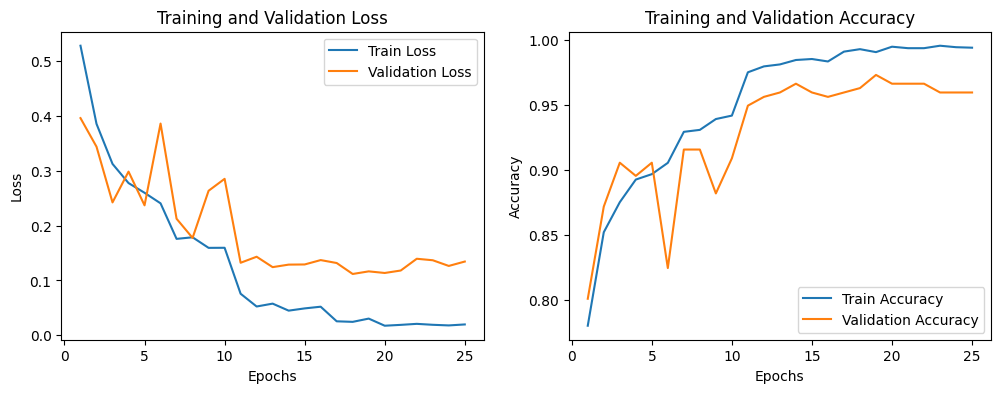

In [20]:
# Find the best result

#model, train_losses, val_losses, train_accuracies, val_accuracies
evaluate_model(model, test_loader)

print(f"Best step_size: 10, Best gamma: 0.1, Validation Accuracy: {max(val_accuracies)}")

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)


In [21]:
model2 = create_model()
optimizer2 = optim.Adam(model2.parameters(), lr=0.001)
scheduler2 = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.01)

model2, train_losses2, val_losses2, train_accuracies2, val_accuracies2 = train_model(
            model2, criterion, optimizer2, scheduler2, train_loader, val_loader, num_epochs=25, patience=10
        )
evaluate_model(model2, test_loader)

Epoch [1/25] Train Loss: 0.5278, Train Acc: 0.7875, Val Loss: 0.7072, Val Acc: 0.7399


/opt/conda/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:136: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn("Detected call of `lr_scheduler.step()` before `optimizer.step()`. "


Epoch [2/25] Train Loss: 0.3991, Train Acc: 0.8447, Val Loss: 0.3470, Val Acc: 0.8446
Epoch [3/25] Train Loss: 0.2961, Train Acc: 0.8837, Val Loss: 0.2329, Val Acc: 0.9122
Epoch [4/25] Train Loss: 0.2798, Train Acc: 0.8856, Val Loss: 0.3036, Val Acc: 0.8615
Epoch [5/25] Train Loss: 0.2223, Train Acc: 0.9129, Val Loss: 0.3633, Val Acc: 0.8547
Epoch [6/25] Train Loss: 0.2141, Train Acc: 0.9205, Val Loss: 0.2619, Val Acc: 0.8716
Epoch [7/25] Train Loss: 0.2046, Train Acc: 0.9178, Val Loss: 0.2860, Val Acc: 0.8818
Epoch [8/25] Train Loss: 0.1990, Train Acc: 0.9258, Val Loss: 0.4749, Val Acc: 0.8480
Epoch [9/25] Train Loss: 0.1628, Train Acc: 0.9375, Val Loss: 0.1971, Val Acc: 0.9020
Epoch [10/25] Train Loss: 0.1998, Train Acc: 0.9197, Val Loss: 0.6517, Val Acc: 0.8074
Epoch [11/25] Train Loss: 0.1585, Train Acc: 0.9330, Val Loss: 0.2399, Val Acc: 0.9088
Epoch [12/25] Train Loss: 0.1245, Train Acc: 0.9508, Val Loss: 0.1858, Val Acc: 0.9358
Epoch [13/25] Train Loss: 0.1129, Train Acc: 0.9557

Epoch [1/50] Train Loss: 0.5579, Train Acc: 0.7739, Val Loss: 0.5131, Val Acc: 0.7905
Epoch [2/50] Train Loss: 0.3647, Train Acc: 0.8432, Val Loss: 0.4099, Val Acc: 0.8311
Epoch [3/50] Train Loss: 0.3069, Train Acc: 0.8780, Val Loss: 0.4327, Val Acc: 0.8243
Epoch [4/50] Train Loss: 0.2630, Train Acc: 0.8973, Val Loss: 0.3453, Val Acc: 0.8480
Epoch [5/50] Train Loss: 0.2441, Train Acc: 0.9091, Val Loss: 0.3249, Val Acc: 0.8514
Epoch [6/50] Train Loss: 0.2474, Train Acc: 0.9076, Val Loss: 0.5237, Val Acc: 0.8074
Epoch [7/50] Train Loss: 0.1715, Train Acc: 0.9284, Val Loss: 0.1925, Val Acc: 0.9122
Epoch [8/50] Train Loss: 0.1710, Train Acc: 0.9352, Val Loss: 0.2500, Val Acc: 0.9257
Epoch [9/50] Train Loss: 0.1771, Train Acc: 0.9307, Val Loss: 0.3272, Val Acc: 0.8716
Epoch [10/50] Train Loss: 0.1372, Train Acc: 0.9508, Val Loss: 0.3108, Val Acc: 0.8649
Epoch [11/50] Train Loss: 0.1199, Train Acc: 0.9648, Val Loss: 0.1334, Val Acc: 0.9595
Epoch [12/50] Train Loss: 0.0546, Train Acc: 0.9788,

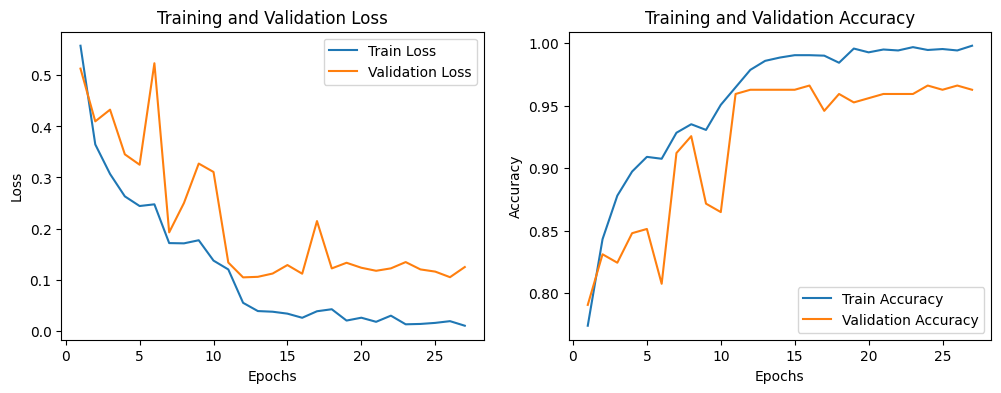

In [24]:
model = create_model()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)

model, train_losses, val_losses, train_accuracies, val_accuracies = train_model(
            model, criterion, optimizer, scheduler, train_loader, val_loader, num_epochs=50, patience=15
        )

evaluate_model(model, test_loader)
# Find the best result

#model, train_losses, val_losses, train_accuracies, val_accuracies
evaluate_model(model, test_loader)

print(f"Best step_size: 10, Best gamma: 0.1, Validation Accuracy: {max(val_accuracies)}")

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)
